# Reweighting

*Properties of the reweighting procedure for observable $\Sigma$*

## Function definitions

- load the necessary modules:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

- read complex eigenvalues of one configuration:

In [2]:
def readCEVs(eigFile):
# eigFile - name of .eig file with eigenvalues
    cevs = np.loadtxt(eigFile)
    return np.array([np.complex128(cev[0] + cev[1] * 1j) for cev in cevs])

- read complex eigenvalues of all configurations at once:

In [3]:
def readAllCEVs(eigFilesList):
# eigFilesList - list of .eig file names
    f = open(eigFilesList, "r")
    allCEVs = []
    for eigFileName in f:
        allCEVs.append(readCEVs(eigFileName.strip()))
    f.close()
    return allCEVs

- absolute value of topological charge is equal to the number of zero modes:

In [4]:
def countZeros(cevs):
# cevs - complex eigenvalues of one configuration
    return len([cev for cev in cevs if abs(cev) < 1e-12])

- computes determinant of a massive overlap operator using eigenvalues:

In [5]:
def detM(cevs, qm, nmz, out):
# cevs - complex eigenvalues
# qm - quark mass
# nmz - numerical normalization (about 0.63 is optimal)
# out - print complex p if True
    f = 1.0 - qm / 2.0
    p = np.complex128(1 + 0j)
    for i in range(len(cevs)):
        p *= (f * cevs[i] + qm) * nmz
    if out: print(p)
    return p.real

- computes normalized determinants (max = 1) of an ensemble:

In [6]:
def detEnMax1(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]
    dmax = max(dets)
    return [d / dmax for d in dets]

- sort determinants according to absolute topological charge:

In [7]:
def QdetEnMax1(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass

    # compute determinants for all configuration
    dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]

    # normalize determinants to max is equal to one
    dmax = max(dets)
    dets = [d / dmax for d in dets]

    # compute absolute topological charge
    Qs = [countZeros(cevs) for cevs in allCEVs]

    # find maximal topological charge
    Qmax = int(max(Qs))
    print("Qmax =", Qmax)

    # create Qmax + 1 empty lists
    Qdet = []
    for i in range(Qmax + 1): Qdet.append([])

    # add determinants according to topological charge
    for i in range(len(dets)):
        Qdet[Qs[i]].append(dets[i])
        
    # how many entries are in each topological sector
    print([len(Qdet[i]) for i in range(Qmax + 1)])
    print()
    
    return Qdet

- compute $\Sigma$ from complex eigenvalues for a given quark mass `qm`:

In [8]:
def sigma(cevs, qm, out):
# cevs - list of complex eigenvalues
# qm - quark mass
# out - if True sigma is printed
    f = 1.0 - qm / 2.0
    s = np.complex128(0.0 + 0.0j) # sum
    for i in range(len(cevs)):
        s += (1.0 - 0.5 * cevs[i]) / (f * cevs[i] + qm)
    # len(cevs) is 2 * L^2 because of 2 spinor components
    sig = s / (len(cevs) * 0.5) # division by L^2
    if out: print(sig) # imaginary part should be near zero 
    return sig.real

- compute $\Sigma$ for a given quark mass `qm` for all configurations:

In [9]:
def sigmaEn(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    sigmas = [sigma(cevs, qm, False) for cevs in allCEVs]
    return sigmas

## Examples

- read complex eigenvalues of one configuration:

In [10]:
cevs = readCEVs("/mnt/e/Jaime/b4_20x20Ov/Eig/L020x020_b04000i00001-HO.eig")
cevs[0]

(0.00213644822675577-0.0653324731085987j)

- compute determinant for quark mass 0.05:

In [11]:
detM(cevs, 0.05, 0.63, True)

(2.6583807559420576-1.992850329202156e-14j)


2.6583807559420576

- compute absolute value of topological charge:

In [12]:
countZeros(cevs)

1

In [13]:
sigma(cevs, 0.05, True)

(0.12887504928843335-3.924811864397526e-16j)


0.12887504928843335

## Results

- read complex eigenvalues of all configurations from an ensemble:

In [14]:
%%time
allCEVs = readAllCEVs("/mnt/e/Jaime/b4_20x20Ov/eigFiles.list")

CPU times: user 52.9 s, sys: 5.92 s, total: 58.8 s
Wall time: 5min 44s


### Check $\Sigma$ reweighting

In [75]:
def sigVqm(allCEVs, maxNf, qmMin, qmMax, qmStep):
    qms = np.arange(qmMin, qmMax, qmStep)
    sigqm = [[qms, []] for i in range(maxNf + 1)]
    for qm in qms:
        dets = detEnMax1(allCEVs, qm)
        sigmas = sigmaEn(allCEVs, qm)
        for Nf in range(maxNf + 1):
            detNf = [d**Nf for d in dets]
            sumdetNf = sum(detNf)
            sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
            sigqm[Nf][1].append(sum(sigdetNf))
    return sigqm

In [76]:
%%time
sigqm = sigVqm(allCEVs, 2, 0.005, 0.151, 0.005)

CPU times: user 13min 31s, sys: 30 ms, total: 13min 31s
Wall time: 13min 31s


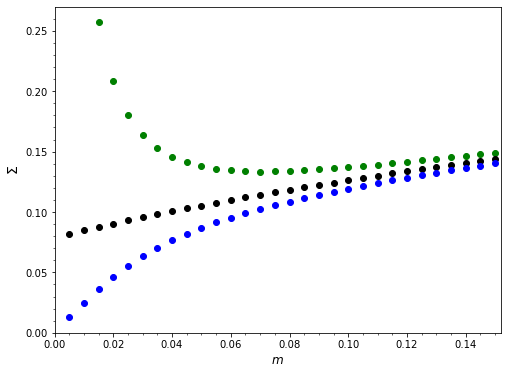

In [169]:
fig, p = plt.subplots(figsize = (8, 6))
p.set_xlabel("$m$", fontsize = 12)
p.set_ylabel(r"$\Sigma$", fontsize = 14)
p.set_xlim(0.0, 0.152)
p.set_ylim(0.0, 0.27)
p.set_xticks(np.arange(0, 0.152, 0.005), minor = True)
p.set_yticks(np.arange(0, 0.27, 0.01), minor = True)

p.scatter(sigqm[0][0], sigqm[0][1], color = "green")
p.scatter(sigqm[1][0], sigqm[1][1], color = "black")
p.scatter(sigqm[2][0], sigqm[2][1], color = "blue");

- correction for $\beta$, i.e. $g = 1/\sqrt{\beta}$:

In [78]:
beta = 4.0
g = 1.0 / np.sqrt(beta)
gsigqm = [[[sigqm[j][k][i] / g for i in range(len(sigqm[j][k]))] for k in range(len(sigqm[j]))] for j in range(len(sigqm))]

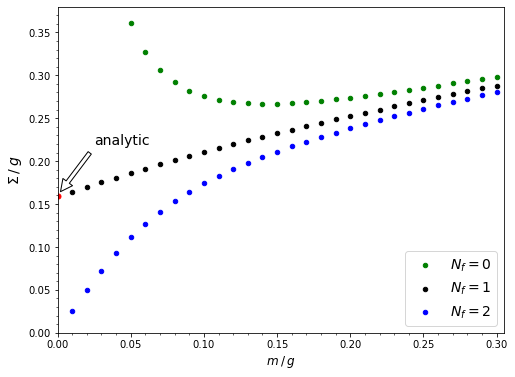

In [168]:
fig, p = plt.subplots(figsize = (8, 6))
p.set_xlabel("$m\:/\:g$", fontsize = 12)
p.set_ylabel(r"$\Sigma\:/\:g$", fontsize = 14)
p.set_xlim(0.0, 0.305)
p.set_ylim(0.0, 0.38)
p.set_xticks(np.arange(0, 0.305, 0.01), minor = True)
p.set_yticks(np.arange(0, 0.38, 0.01), minor = True)

p.scatter(gsigqm[0][0], gsigqm[0][1], s = 20, c = "green", label = "$N_f = 0$")
p.scatter(gsigqm[1][0], gsigqm[1][1], s = 20, c = "black", label = "$N_f = 1$")
p.scatter(gsigqm[2][0], gsigqm[2][1], s = 20, c = "blue", label = "$N_f = 2$")
p.plot(0.0, 0.1599, marker = "o", color = "red", markersize = 5)

p.annotate("analytic", xy = (0, 0.1599), xytext=(0.025, 0.22), fontsize = 14,
    arrowprops=dict(facecolor = "white", edgecolor = "black", shrink = 0.08))
p.legend(loc = "lower right", fontsize = 14);

- plot above can be directly compared to Fig. 1 in Duerr/Hoelbling Phys. Rev. D 69 (2004) 034503
- analytic result for $\Sigma/g$ for one flavor is 0.1599

### $\Sigma$ distributions

#### $\Sigma$ distribution (quenched) / m = 0.05

In [20]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)

CPU times: user 4.81 s, sys: 59 µs, total: 4.81 s
Wall time: 4.8 s


In [21]:
sum(sigmas) / len(sigmas) # average sigma (quenched)

0.13781632229894217

In [22]:
(min(sigmas), max(sigmas))

(0.05161850479558079, 0.3825240626525837)

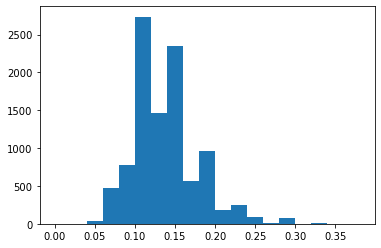

In [23]:
plt.hist(sigmas, bins = [r for r in np.arange(0.0, 0.4, 0.02)]);

#### $\Sigma$ times determinant (1 flavor) per configuration distribution / m = 0.05

In [24]:
%%time
dets = detEnMax1(allCEVs, 0.05)
sumdet1 = sum(dets)

CPU times: user 3.12 s, sys: 46 µs, total: 3.12 s
Wall time: 3.12 s


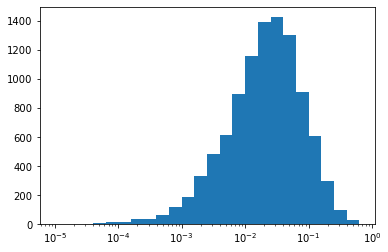

In [25]:
plt.xscale('log')
plt.hist(dets, bins = [10.0**r for r in np.arange(-5.0, 0, 0.2)]);

In [26]:
%%time
sigdet1 = [sigmas[i] * dets[i] / sumdet1 for i in range(len(sigmas))]
print("sigma = ", sum(sigdet1))
print()

sigma =  0.10531380923744617

CPU times: user 1.89 ms, sys: 10 µs, total: 1.9 ms
Wall time: 1.9 ms


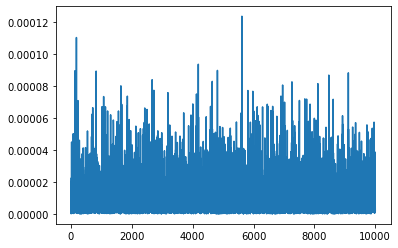

In [27]:
plt.plot(range(1, len(sigdet1) + 1), sigdet1);

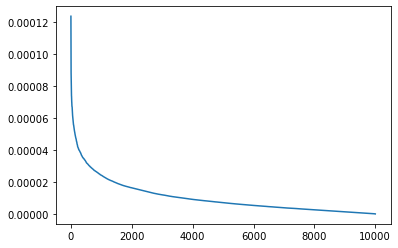

In [28]:
sigdet1.sort(reverse = True)
plt.plot(range(1, len(sigdet1) + 1), sigdet1);

In [29]:
(min(sigdet1), max(sigdet1))

(5.10535900242812e-09, 0.00012364615039179075)

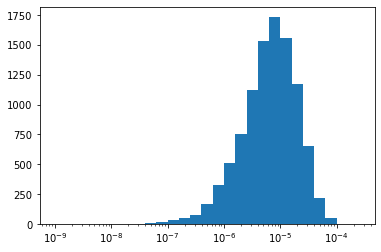

In [30]:
plt.xscale('log')
plt.hist(sigdet1, bins = [10.0**r for r in np.arange(-9.0, -3.5, 0.2)]);

#### $\Sigma$ times squared determinant (2 flavors) per configuration distribution / m = 0.05

In [31]:
%%time
dets = detEnMax1(allCEVs, 0.05)
det2 = [d**2 for d in dets]
sumdet2 = sum(det2)

CPU times: user 3.13 s, sys: 38 µs, total: 3.13 s
Wall time: 3.13 s


In [32]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)
sigdet2 = [sigmas[i] * det2[i] / sumdet2 for i in range(len(sigmas))]
print("sigma = ", sum(sigdet2))
print()

sigma =  0.08698086336108671

CPU times: user 4.61 s, sys: 0 ns, total: 4.61 s
Wall time: 4.61 s


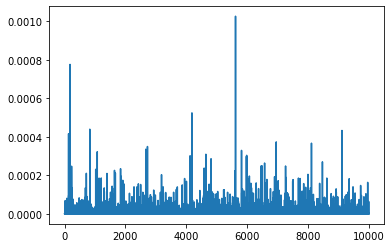

In [33]:
plt.plot(range(1, len(sigdet2) + 1), sigdet2);

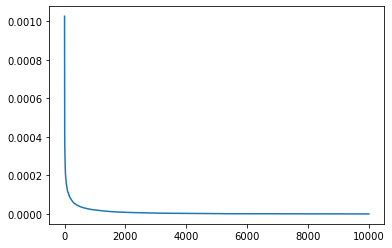

In [34]:
sigdet2.sort(reverse = True)
plt.plot(range(1, len(sigdet2) + 1), sigdet2);

In [35]:
(min(sigdet2), max(sigdet2))

(2.663528532107877e-13, 0.0010261970380362583)

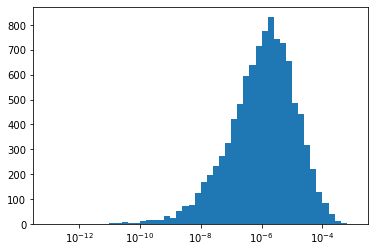

In [36]:
plt.xscale('log')
plt.hist(sigdet2, bins = [10.0**r for r in np.arange(-13.0, -2.8, 0.2)]);

### Cumulative plots

In [15]:
def cumSigmaNf(sigmas, dets, Nf):
    detNf = [d**Nf for d in dets]
    sumdetNf = sum(detNf)
    sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
    sigmaNf = sum(sigdetNf)
    sigdetNf.sort(reverse = True)
    csigdetNf = [sum(sigdetNf[:i]) / sigmaNf for i in range(1, len(sigdetNf) + 1)]
    return sigmaNf, csigdetNf 

In [16]:
def cumSigma(allCEVs, qm, flavors):
    fig, p = plt.subplots(figsize = (8, 5))  
    print("Nf    sigma     50%   90%   99%")
    print("===============================")
    dets = detEnMax1(allCEVs, qm)
    sigmas = sigmaEn(allCEVs, qm)
    for flavor in flavors:
        Nf, NfColor, NfLabel = flavor
        sigmaNf, csNf = cumSigmaNf(sigmas, dets, Nf)
        s50 = len([cs for cs in csNf if cs <= 0.50])
        s90 = len([cs for cs in csNf if cs <= 0.90])
        s99 = len([cs for cs in csNf if cs <= 0.99])
        print("%2d  %9.7f %5d %5d %5d " % (Nf, sigmaNf, s50, s90, s99))
        p.plot(range(1, len(csNf) + 1), csNf, color = NfColor, label = NfLabel)
    p.legend(loc = "lower right", fontsize = 14)

In [17]:
flavors = [[1, "black", "$N_f = 1$"], [2, "blue", "$N_f = 2$"],
    [4, "green", "$N_f = 4$"], [6, "violet", "$N_f = 6$"]]

#### m = 0.2

Nf    sigma     50%   90%   99%
 1  0.1593495  3058  7675  9579 
 2  0.1570204  1627  5893  8830 
 4  0.1536070   365  2584  6153 
 6  0.1514763    91   910  3242 


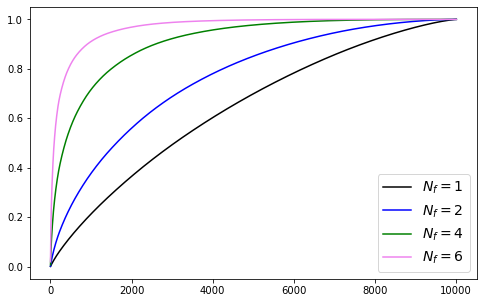

In [23]:
cumSigma(allCEVs, 0.2, flavors)

#### m = 0.1

Nf    sigma     50%   90%   99%
 1  0.1262986  2311  6828  9251 
 2  0.1191389   806  4038  7529 
 4  0.1099706    87   899  3132 
 6  0.1039011    13   178   938 


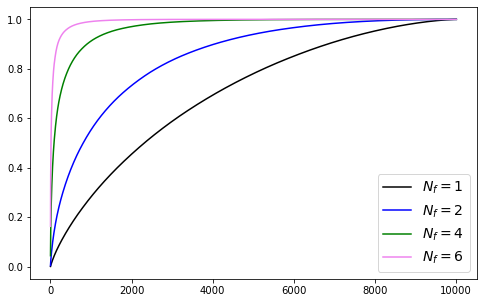

In [40]:
cumSigma(allCEVs, 0.1, flavors)

#### m = 0.05

Nf    sigma     50%   90%   99%
 1  0.1053138  1789  5992  8791 
 2  0.0869809   412  2611  5974 
 4  0.0653109    16   275  1325 
 6  0.0561419     1    23   203 


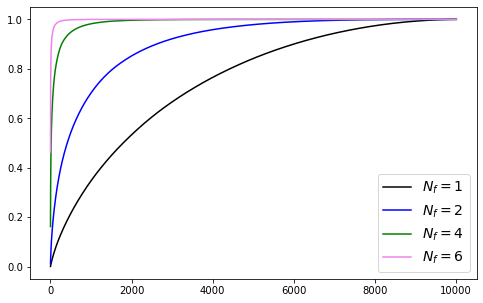

In [41]:
cumSigma(allCEVs, 0.05, flavors)

#### m = 0.01

Nf    sigma     50%   90%   99%
 1  0.0848037  1094  4497  7519 
 2  0.0248797   223  1499  3796 
 4  0.0126283     4    68   359 
 6  0.0113806     0     8    58 


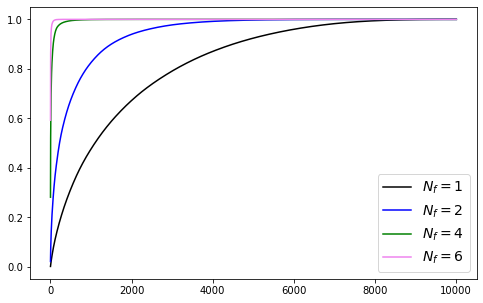

In [42]:
cumSigma(allCEVs, 0.01, flavors)

#### m = 0.001

Nf    sigma     50%   90%   99%
 1  0.0794827   665  2473  5404 
 2  0.0025516   214  1434  3455 
 4  0.0012563     3    63   266 
 6  0.0011394     0     8    57 


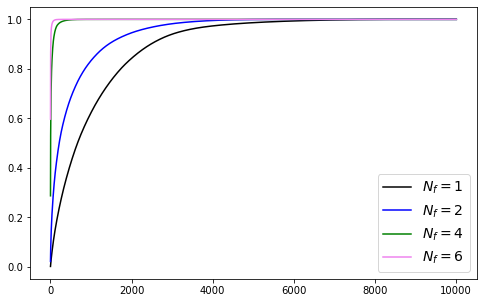

In [18]:
cumSigma(allCEVs, 0.001, flavors)

In [22]:
def cumSigmaVqm(allCEVs, qmMin, qmMax, qmStep, flavors, perc):
    maxNf = max([flavor[0] for flavor in flavors])
    sperc = [[] for i in range(maxNf + 1)]
    qms = np.arange(qmMin, qmMax, qmStep)
    for qm in qms:
        dets = detEnMax1(allCEVs, qm)
        sigmas = sigmaEn(allCEVs, qm)
        for flavor in flavors:
            Nf = flavor[0]
            sigmaNf, csNf = cumSigmaNf(sigmas, dets, Nf)
            sperc[Nf].append(len([cs for cs in csNf if cs <= perc]))
            print("%4.2f  %2d  %9.7f  %5d" % (qm, Nf, sigmaNf, sperc[Nf][-1]))
        print()
    fig, p = plt.subplots(figsize = (8, 5))
    for flavor in flavors:
        Nf, NfColor, NfLabel = flavor
        p.plot(qms, sperc[Nf], color = NfColor, label = NfLabel)
    p.set_xlim(0, None)
    p.set_ylim(0, None)
    p.legend(loc = "lower right", fontsize = 14)

0.02   1  0.0903653   8097
0.02   2  0.0464853   4432
0.02   4  0.0255952    543
0.02   6  0.0226922     65

0.04   1  0.1005795   8625
0.04   2  0.0767141   5511
0.04   4  0.0524373   1025
0.04   6  0.0450578    131

0.06   1  0.1098417   8921
0.06   2  0.0953187   6375
0.06   4  0.0769759   1670
0.06   6  0.0670624    297

0.08   1  0.1183687   9116
0.08   2  0.1085336   7031
0.08   4  0.0958659   2401
0.08   6  0.0873344    584

0.10   1  0.1262986   9251
0.10   2  0.1191389   7529
0.10   4  0.1099706   3132
0.10   6  0.1039011    938

0.12   1  0.1337212   9351
0.12   2  0.1282610   7919
0.12   4  0.1211848   3847
0.12   6  0.1168222   1337

0.14   1  0.1406976   9428
0.14   2  0.1364035   8229
0.14   4  0.1306898   4512
0.14   6  0.1273020   1787

0.16   1  0.1472726   9489
0.16   2  0.1438221   8474
0.16   4  0.1390803   5125
0.16   6  0.1362733   2261

0.18   1  0.1534805   9538
0.18   2  0.1506634   8670
0.18   4  0.1466619   5673
0.18   6  0.1442429   2738

0.20   1  0.1593495

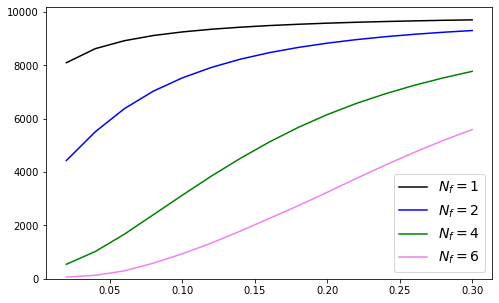

In [41]:
%%time
cumSigmaVqm(allCEVs, 0.02, 0.301, 0.02, flavors, 0.99)

0.00   1  0.0794827   5404
0.00   2  0.0025516   3455
0.00   4  0.0012563    266
0.00   6  0.0011394     57

0.01   1  0.0824784   7119
0.01   2  0.0151707   3581
0.01   4  0.0075521    301
0.01   6  0.0068334     57

0.01   1  0.0853756   7601
0.01   2  0.0272269   3859
0.01   4  0.0139056    377
0.01   6  0.0125157     59

0.02   1  0.0881816   7916
0.02   2  0.0383679   4185
0.02   4  0.0203543    463
0.02   6  0.0181787     61

0.02   1  0.0909032   8135
0.02   2  0.0483986   4491
0.02   4  0.0269170    563
0.02   6  0.0238181     66

0.03   1  0.0935466   8299
0.03   2  0.0572734   4778
0.03   4  0.0335875    670
0.03   6  0.0294336     74

0.03   1  0.0961176   8432
0.03   2  0.0650550   5050
0.03   4  0.0403306    785
0.03   6  0.0350279     89

0.04   1  0.0986215   8546
0.04   2  0.0718666   5311
0.04   4  0.0470835    914
0.04   6  0.0406055    110

0.04   1  0.1010630   8643
0.04   2  0.0778520   5560
0.04   4  0.0537629   1053
0.04   6  0.0461696    138

0.05   1  0.1034464

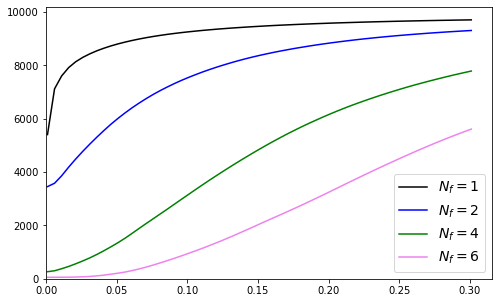

In [26]:
%%time
cumSigmaVqm(allCEVs, 0.001, 0.302, 0.005, flavors, 0.99)

0.00   1  0.0794827   5404
0.00   2  0.0025516   3455
0.00   4  0.0012563    266
0.00   6  0.0011394     57

0.00   1  0.0800901   6191
0.00   2  0.0050991   3466
0.00   4  0.0025131    269
0.00   6  0.0022787     57

0.00   1  0.0806933   6570
0.00   2  0.0076387   3483
0.00   4  0.0037706    274
0.00   6  0.0034178     57

0.00   1  0.0812923   6810
0.00   2  0.0101663   3508
0.00   4  0.0050294    281
0.00   6  0.0045567     57

0.01   1  0.0818873   6982
0.01   2  0.0126782   3541
0.01   4  0.0062898    290
0.01   6  0.0056953     57

0.01   1  0.0824784   7119
0.01   2  0.0151707   3581
0.01   4  0.0075521    301
0.01   6  0.0068334     57

0.01   1  0.0830655   7234
0.01   2  0.0176403   3627
0.01   4  0.0088168    314
0.01   6  0.0079711     57

0.01   1  0.0836487   7336
0.01   2  0.0200837   3680
0.01   4  0.0100842    328
0.01   6  0.0091082     58

0.01   1  0.0842281   7431
0.01   2  0.0224978   3736
0.01   4  0.0113546    343
0.01   6  0.0102448     58

0.01   1  0.0848037

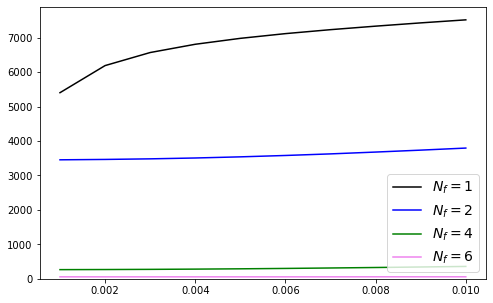

In [20]:
%%time
cumSigmaVqm(allCEVs, 0.001, 0.011, 0.001, flavors, 0.99)

## Topology

- topological charge of the first $n$ configurations which contribute most to the final value of $\Sigma$:

In [47]:
# key function for sorting: uses value of element[3]
def element3(element):
    return element[3]

def Q_first_n(allCEVs, qm, Nf, first_n):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
# Nf - number of flavors
# first_n - first n configurations of the sorted list

    # compute Qs, dets and sigmas for all configurations
    sdNf = [[countZeros(cevs),  detM(cevs, qm, 0.63, False),
            sigma(cevs, qm, False), 0.0] for cevs in allCEVs]
    
    # apply appropriate reweighting
    for i in range(len(sdNf)):
        sdNf[i][3] = sdNf[i][1]**Nf * sdNf[i][2]
    
    # sort according to the reweighted contributions
    sdNf.sort(key = element3, reverse = True)
    
    # take Q of the first n elements
    Qn = [sdNf[i][0] for i in range(first_n)]
    
    # how many entries are in each topological sector
    Qmax = int(max(Qn))
    Qc = [0 for i in range(Qmax + 1)]    
    for Q in Qn: Qc[Q] += 1
    print(Qc)
    print()
    
    return sdNf

- consistency check - distribution of all configurations:

In [50]:
%%time
sdNf = Q_first_n(allCEVs, 0.05, 6, 10000)

[2307, 3844, 2365, 1050, 335, 78, 17, 4]

CPU times: user 8.39 s, sys: 4 µs, total: 8.39 s
Wall time: 8.39 s


- 203 configurations which contribute 99% for 6 flavors at $m = 0.05$:

In [54]:
%%time
sdNf = Q_first_n(allCEVs, 0.05, 6, 203)

[140, 63]

CPU times: user 8.41 s, sys: 3 µs, total: 8.41 s
Wall time: 8.41 s


In [55]:
sdNf[:30]

[[0, 174.81634303913913, 0.05161850479558079, 1473321772022.0486],
 [0, 148.1777055443309, 0.05433693985870544, 575164893796.7662],
 [0, 118.00547075169494, 0.05789842425801687, 156343415247.27393],
 [0, 103.69711641818486, 0.06286465521273982, 78163971342.50937],
 [0, 103.42884953789174, 0.06226037005613108, 76218756916.6524],
 [0, 97.94781328666153, 0.06671729433801106, 58912424159.653824],
 [0, 97.68090964139992, 0.06023190015638554, 52322048114.42322],
 [0, 94.91565246314849, 0.06265690442045939, 45813762442.33137],
 [0, 95.30215842277269, 0.05921632276779427, 44366774405.91105],
 [0, 92.6105642604723, 0.05784971290440114, 36497606939.12853],
 [0, 89.98797958911001, 0.06260252831701497, 33242898240.88079],
 [0, 91.63119771833273, 0.05569026176222819, 32963964594.583984],
 [0, 84.26850908581346, 0.0726946834775625, 26031219336.862415],
 [0, 84.74653932489463, 0.0645965979806243, 23929932941.72661],
 [0, 86.06235322808352, 0.054830664426151685, 22279365090.217785],
 [0, 82.0860271121

- 58 configurations which contribute 99% for 6 flavors at $m = 0.01$:

In [53]:
%%time
sdNf = Q_first_n(allCEVs, 0.01, 6, 58)

[58]

CPU times: user 8.41 s, sys: 11.8 ms, total: 8.43 s
Wall time: 8.42 s


### Relative contributions to $\Sigma$

- relative contributions to $\Sigma$ from different topological sectors as a function of fermion mass 

In [12]:
def QrsigmaVqm(allCEVs, qmMin, qmMax, qmStep, Nf):
# allCEVs - eigenvalues for all configurations
# qmMin, qmMax, qmStep - range of quark masses
# Nf - number of flavors

    # compute absolute topological charge
    Qs = [countZeros(cevs) for cevs in allCEVs]

    # find maximal topological charge
    Qmax = int(max(Qs))
    print("Qmax =", Qmax)
    Qc = [0 for i in range(Qmax + 1)]
    QrsigNf = [[] for i in range(Qmax + 1)]
    
    # how many entries are in each topological sector
    for Q in Qs: Qc[Q] += 1
    print(Qc)
    print()
    
    # loop over quark masses
    qms = np.arange(qmMin, qmMax, qmStep)
    for qm in qms:
        # compute determinants for all configuration
        dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]

        # compute sigmas for all configurations
        sigmas = [sigma(cevs, qm, False) for cevs in allCEVs]
    
        # reweighting
        detNf = [d**Nf for d in dets]
        sumdetNf = sum(detNf)
        sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
        sigmaNf = sum(sigdetNf)
        print("{0:6.4f}  {1:9.7f}".format(qm, sigmaNf))
    
        # create Qmax + 1 empty lists
        QsdNf = []
        for i in range(Qmax + 1): QsdNf.append([])

        # add sigdets according to topological charge
        for i in range(len(dets)):
            QsdNf[Qs[i]].append(sigdetNf[i])
        
        # relative contribution of each topological sector
        print("   ", end = '')
        for i in range(Qmax + 1):
            QrsigNf[i].append(sum(QsdNf[i]) / sigmaNf)
            print(" {0:8.2e}".format(QrsigNf[i][-1]), end = '')
        print()

    print()
    fig, p = plt.subplots(figsize = (8, 6))
    for i in range(len(QrsigNf)):
        p.plot(qms, QrsigNf[i], label = "$Q = {0:d}$".format(i))
    p.set_xlim(0.0, None)
    p.set_ylim(0.0, 1.0)
    p.set_xlabel("$m$")
    p.set_ylabel("relative contribution to $\Sigma$")
    p.set_yticks(np.arange(0, 1.0, 0.05), minor = True)
    p.legend(loc = "upper right", fontsize = 14)

#### Quenched ($N_f = 0$)

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0001  33.9604501
    9.96e-06 2.83e-01 3.48e-01 2.32e-01 9.86e-02 2.87e-02 7.51e-03 2.06e-03
0.0101  0.3595086
    3.37e-02 2.84e-01 3.34e-01 2.20e-01 9.30e-02 2.70e-02 7.05e-03 1.93e-03
0.0201  0.2074223
    8.24e-02 2.94e-01 3.11e-01 1.98e-01 8.30e-02 2.39e-02 6.22e-03 1.70e-03
0.0301  0.1635375
    1.23e-01 3.08e-01 2.90e-01 1.78e-01 7.30e-02 2.08e-02 5.38e-03 1.47e-03
0.0401  0.1457220
    1.53e-01 3.22e-01 2.75e-01 1.61e-01 6.47e-02 1.82e-02 4.66e-03 1.27e-03
0.0501  0.1377647
    1.73e-01 3.35e-01 2.64e-01 1.48e-01 5.81e-02 1.61e-02 4.08e-03 1.10e-03
0.0601  0.1344071
    1.88e-01 3.45e-01 2.57e-01 1.39e-01 5.31e-02 1.45e-02 3.63e-03 9.77e-04
0.0701  0.1334770
    1.98e-01 3.52e-01 2.52e-01 1.32e-01 4.92e-02 1.32e-02 3.28e-03 8.77e-04
0.0801  0.1339341
    2.05e-01 3.58e-01 2.48e-01 1.26e-01 4.63e-02 1.22e-02 3.00e-03 7.98e-04
0.0901  0.1352276
    2.10e-01 3.63e-01 2.46e-01 1.22e-01 4.40e-02 1.15e-02 2.79e-03 7.35e-04
0.1001  

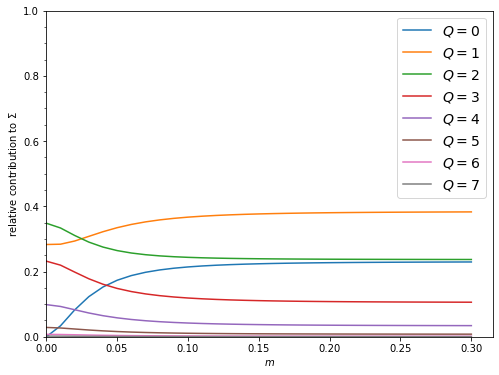

In [13]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 0)

#### 1 flavor

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0001  0.0789324
    2.71e-03 9.96e-01 1.21e-03 6.10e-07 1.42e-10 2.13e-14 2.60e-18 1.12e-22
0.0051  0.0819466
    1.14e-01 8.33e-01 5.10e-02 1.31e-03 1.56e-05 1.18e-07 7.38e-10 1.62e-12
0.0101  0.0848610
    1.89e-01 7.22e-01 8.51e-02 4.29e-03 1.01e-04 1.51e-06 1.86e-08 8.08e-11
0.0151  0.0876830
    2.39e-01 6.44e-01 1.09e-01 8.09e-03 2.82e-04 6.30e-06 1.16e-07 7.50e-10
0.0201  0.0904193
    2.71e-01 5.90e-01 1.26e-01 1.22e-02 5.61e-04 1.66e-05 4.03e-07 3.48e-09
0.0251  0.0930763
    2.92e-01 5.53e-01 1.38e-01 1.64e-02 9.28e-04 3.40e-05 1.03e-06 1.11e-08
0.0301  0.0956599
    3.04e-01 5.26e-01 1.48e-01 2.04e-02 1.37e-03 5.96e-05 2.15e-06 2.77e-08
0.0351  0.0981755
    3.12e-01 5.07e-01 1.56e-01 2.43e-02 1.87e-03 9.40e-05 3.92e-06 5.89e-08
0.0401  0.1006279
    3.15e-01 4.92e-01 1.62e-01 2.80e-02 2.42e-03 1.37e-04 6.48e-06 1.11e-07
0.0451  0.1030215
    3.16e-01 4.82e-01 1.67e-01 3.14e-02 3.00e-03 1.89e-04 9.95e-06 1.92e-07
0.0501  0

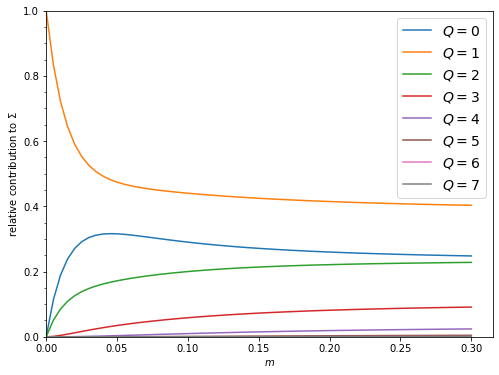

In [14]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.005, 1)

#### 2 flavors

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0001  0.0002552
    6.20e-01 3.80e-01 3.79e-07 1.35e-13 1.53e-20 1.11e-27 5.37e-35 2.99e-43
0.0101  0.0251160
    6.10e-01 3.86e-01 3.79e-03 1.36e-05 1.56e-08 1.15e-11 5.66e-15 3.21e-19
0.0201  0.0466788
    5.85e-01 4.01e-01 1.42e-02 1.94e-04 8.65e-07 2.49e-09 4.81e-12 1.08e-15
0.0301  0.0637300
    5.51e-01 4.19e-01 2.92e-02 8.43e-04 8.20e-06 5.18e-08 2.21e-10 1.12e-13
0.0401  0.0768292
    5.14e-01 4.37e-01 4.67e-02 2.22e-03 3.68e-05 4.02e-07 2.98e-09 2.67e-12
0.0501  0.0870725
    4.80e-01 4.51e-01 6.47e-02 4.41e-03 1.09e-04 1.80e-06 2.03e-08 2.84e-11
0.0601  0.0953947
    4.50e-01 4.60e-01 8.22e-02 7.36e-03 2.50e-04 5.67e-06 8.97e-08 1.80e-10
0.0701  0.1024333
    4.24e-01 4.66e-01 9.85e-02 1.09e-02 4.78e-04 1.41e-05 2.94e-07 8.03e-10
0.0801  0.1085918
    4.02e-01 4.69e-01 1.13e-01 1.49e-02 8.04e-04 2.96e-05 7.76e-07 2.77e-09
0.0901  0.1141230
    3.84e-01 4.69e-01 1.26e-01 1.92e-02 1.23e-03 5.45e-05 1.74e-06 7.86e-09
0.1001  0

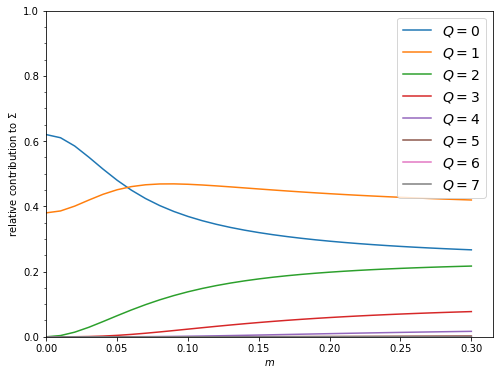

In [15]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 2)

#### 3 flavors

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0001  0.0001377
    9.99e-01 7.08e-04 5.50e-13 1.41e-22 6.76e-33 2.22e-43 3.97e-54 2.55e-66
0.0101  0.0148361
    9.32e-01 6.84e-02 5.28e-05 1.38e-08 6.74e-13 2.27e-17 4.17e-22 2.75e-28
0.0201  0.0308464
    8.64e-01 1.35e-01 7.46e-04 1.46e-06 5.54e-10 1.45e-13 2.08e-17 1.08e-22
0.0301  0.0469139
    7.94e-01 2.02e-01 3.26e-03 2.01e-05 2.48e-08 2.12e-11 1.00e-14 1.76e-19
0.0401  0.0616932
    7.25e-01 2.67e-01 8.65e-03 1.15e-04 3.23e-07 6.32e-10 6.89e-13 2.86e-17
0.0501  0.0744274
    6.59e-01 3.23e-01 1.72e-02 4.04e-04 2.10e-06 7.69e-09 1.59e-11 1.29e-15
0.0601  0.0850699
    6.02e-01 3.68e-01 2.86e-02 1.03e-03 8.76e-06 5.28e-08 1.81e-10 2.55e-14
0.0701  0.0939649
    5.54e-01 4.02e-01 4.18e-02 2.12e-03 2.69e-05 2.44e-07 1.28e-09 2.86e-13
0.0801  0.1015335
    5.14e-01 4.26e-01 5.58e-02 3.74e-03 6.63e-05 8.43e-07 6.30e-09 2.12e-12
0.0901  0.1081289
    4.81e-01 4.43e-01 7.01e-02 5.89e-03 1.38e-04 2.35e-06 2.39e-08 1.15e-11
0.1001  0

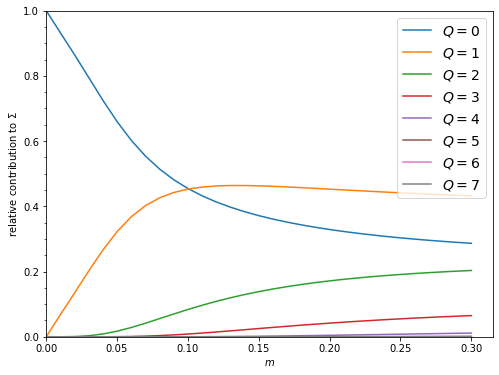

In [16]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 3)

#### 4 flavors

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0001  0.0001256
    1.00e+00 6.62e-07 4.02e-19 7.87e-32 1.38e-45 1.94e-59 1.25e-73 8.46e-90
0.0101  0.0127559
    9.93e-01 6.87e-03 4.18e-07 8.37e-12 1.52e-17 2.21e-23 1.47e-29 1.04e-37
0.0201  0.0257272
    9.72e-01 2.83e-02 2.44e-05 7.28e-09 2.03e-13 4.55e-18 4.71e-23 5.21e-30
0.0301  0.0391140
    9.34e-01 6.60e-02 2.46e-04 3.40e-07 4.63e-11 5.08e-15 2.59e-19 1.44e-25
0.0401  0.0525701
    8.80e-01 1.19e-01 1.16e-03 4.57e-06 1.88e-09 6.25e-13 9.74e-17 1.72e-22
0.0501  0.0654343
    8.16e-01 1.80e-01 3.54e-03 3.01e-05 2.86e-08 2.21e-11 8.10e-15 3.51e-20
0.0601  0.0770851
    7.50e-01 2.42e-01 8.08e-03 1.24e-04 2.30e-07 3.49e-10 2.54e-13 2.30e-18
0.0701  0.0872361
    6.87e-01 2.98e-01 1.50e-02 3.68e-04 1.19e-06 3.13e-09 4.01e-12 6.78e-17
0.0801  0.0959466
    6.32e-01 3.43e-01 2.41e-02 8.64e-04 4.44e-06 1.86e-08 3.85e-11 1.12e-15
0.0901  0.1034559
    5.85e-01 3.79e-01 3.49e-02 1.70e-03 1.30e-05 8.09e-08 2.53e-10 1.19e-14
0.1001  0

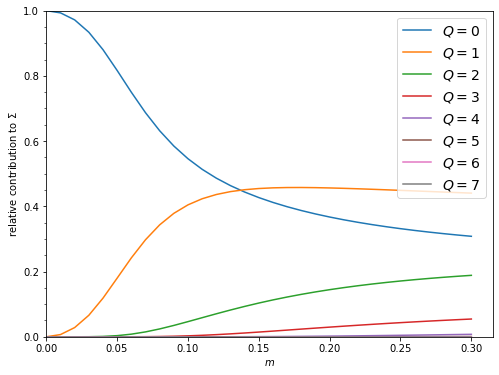

In [17]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 4)

#### 5 flavors

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0001  0.0001182
    1.00e+00 5.31e-10 2.58e-25 3.99e-41 2.32e-58 1.36e-75 3.08e-93 2.07e-113
0.0101  0.0119313
    9.99e-01 5.61e-04 2.75e-09 4.38e-15 2.66e-22 1.63e-29 3.85e-37 2.72e-47
0.0201  0.0237494
    9.95e-01 4.69e-03 6.40e-07 3.01e-11 5.59e-17 1.05e-22 7.64e-29 1.69e-37
0.0301  0.0356487
    9.83e-01 1.68e-02 1.47e-05 4.75e-09 6.43e-14 8.82e-19 4.72e-24 7.90e-32
0.0401  0.0476572
    9.58e-01 4.16e-02 1.25e-04 1.51e-07 8.20e-12 4.52e-16 9.82e-21 6.95e-28
0.0501  0.0596132
    9.18e-01 8.11e-02 5.98e-04 1.91e-06 2.99e-10 4.76e-14 3.02e-18 6.58e-25
0.0601  0.0711358
    8.65e-01 1.33e-01 1.94e-03 1.31e-05 4.81e-09 1.78e-12 2.68e-16 1.47e-22
0.0701  0.0817809
    8.04e-01 1.91e-01 4.74e-03 5.83e-05 4.31e-08 3.21e-11 9.87e-15 1.18e-20
0.0801  0.0912632
    7.44e-01 2.47e-01 9.42e-03 1.88e-04 2.51e-07 3.37e-10 1.90e-13 4.49e-19
0.0901  0.0995455
    6.88e-01 2.96e-01 1.60e-02 4.74e-04 1.06e-06 2.34e-09 2.22e-12 9.63e-18
0.1001  

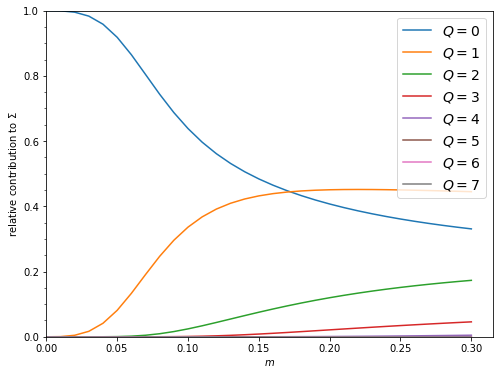

In [18]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 5)

#### 6 flavors

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0001  0.0001139
    1.00e+00 3.92e-13 1.55e-31 1.90e-50 3.49e-71 8.55e-92 6.57e-113 4.19e-137
0.0101  0.0114942
    1.00e+00 4.18e-05 1.68e-11 2.14e-18 4.14e-27 1.07e-35 8.67e-45 5.88e-57
0.0201  0.0228048
    9.99e-01 6.97e-04 1.55e-08 1.15e-13 1.35e-20 2.12e-27 1.05e-34 4.45e-45
0.0301  0.0340223
    9.96e-01 3.78e-03 7.91e-07 6.00e-11 7.67e-17 1.31e-22 7.15e-29 3.44e-38
0.0401  0.0451690
    9.87e-01 1.27e-02 1.19e-05 4.43e-09 3.02e-14 2.75e-19 8.09e-25 2.19e-33
0.0501  0.0562522
    9.68e-01 3.16e-02 8.88e-05 1.07e-07 2.62e-12 8.56e-17 9.16e-22 9.56e-30
0.0601  0.0671701
    9.36e-01 6.38e-02 4.12e-04 1.24e-06 8.46e-11 7.65e-15 2.31e-19 7.30e-27
0.0701  0.0776691
    8.90e-01 1.08e-01 1.35e-03 8.38e-06 1.34e-09 2.81e-13 2.02e-17 1.63e-24
0.0801  0.0874274
    8.36e-01 1.60e-01 3.38e-03 3.79e-05 1.24e-08 5.30e-12 7.92e-16 1.45e-22
0.0901  0.0962128
    7.79e-01 2.14e-01 6.91e-03 1.26e-04 7.67e-08 6.00e-11 1.68e-14 6.41e-21
0.1001 

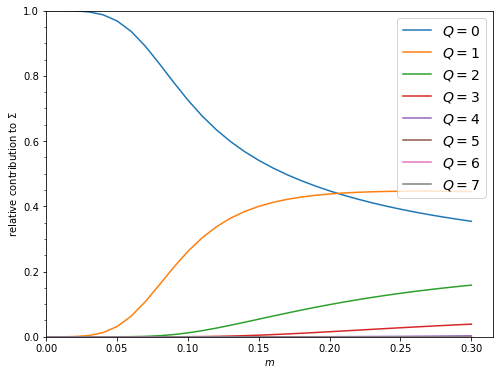

In [19]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 6)

#### $\Sigma$ in different topological sectors

- crosscheck with the Jaime's `PbPOverlap.pdf` report

- $\Sigma$ computed separately in each topological sector as a function of quark mass:

In [72]:
def QsigmaVqm(allCEVs, qmMin, qmMax, qmStep, Nf, g):
# allCEVs - eigenvalues for all configurations
# qmMin, qmMax, qmStep - range of quark masses
# Nf - number of flavors
# g - gauge coupling

    # compute absolute topological charge
    Qs = [countZeros(cevs) for cevs in allCEVs]

    # find maximal topological charge
    Qmax = int(max(Qs))
    print("Qmax =", Qmax)
    
    # how many entries are in each topological sector
    Qc = [0 for iq in range(Qmax + 1)]
    for Q in Qs: Qc[Q] += 1
    print(Qc)
    print()
    
    # prepare lists for sigma in different topological sectors
    QsigmaNf = [[] for iq in range(Qmax + 1)]
        
    # loop over quark masses
    qms = np.arange(qmMin, qmMax, qmStep)
    for qm in qms:
        print("{:6.4f}:".format(qm), end = '')
        
        # compute determinants for all configuration
        dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]

        # compute sigmas for all configurations
        sigmas = [sigma(cevs, qm, False) for cevs in allCEVs]
        
        # sort according to topological charge
        QdetsNf = [[] for iq in range(Qmax + 1)]
        QsdNf = [[] for iq in range(Qmax + 1)]
        for i in range(len(dets)):
            d = dets[i]**Nf
            QdetsNf[Qs[i]].append(d)
            QsdNf[Qs[i]].append(sigmas[i] * d)
    
        # sigma for each topological sector
        for iq in range(Qmax + 1):
            QsigmaNf[iq].append(sum(QsdNf[iq]) / sum(QdetsNf[iq]))
            print(" {0:8.2e}".format(QsigmaNf[iq][-1]), end = '')
        print()

        # division by gauge coupling g
        gqms = [qm / g for qm in qms]
        gQsigmaNf = [[s / g for s in QsigmaNf[iq]] for iq in range(Qmax + 1)]
        
    print()
    fig, p = plt.subplots(figsize = (8, 5.5))
    for iq in range(len(QsigmaNf)):
        p.plot(gqms, gQsigmaNf[iq], label = "$Q = {0:d}$".format(iq))
    p.set_xlim(0.0, 0.4)
    p.set_ylim(0.0, 0.5)
    p.set_xlabel("$m\:/\:g$", fontsize = 12)
    p.set_ylabel(r"$\Sigma\:/\:g$", fontsize = 14)
    p.set_yticks(np.arange(0, 0.2, 0.01), minor = True)
    p.legend(loc = "lower right", fontsize = 14)

Qmax = 7
[2307, 3844, 2365, 1050, 335, 78, 17, 4]

0.0050: 7.90e-03 5.06e-01 1.00e+00 1.50e+00 2.00e+00 2.50e+00 3.00e+00 3.50e+00
0.0100: 1.58e-02 2.61e-01 5.09e-01 7.58e-01 1.01e+00 1.26e+00 1.51e+00 1.76e+00
0.0150: 2.36e-02 1.84e-01 3.47e-01 5.12e-01 6.77e-01 8.43e-01 1.01e+00 1.18e+00
0.0200: 3.12e-02 1.48e-01 2.68e-01 3.91e-01 5.14e-01 6.38e-01 7.62e-01 8.87e-01
0.0250: 3.87e-02 1.28e-01 2.23e-01 3.20e-01 4.18e-01 5.16e-01 6.15e-01 7.16e-01
0.0300: 4.60e-02 1.17e-01 1.94e-01 2.74e-01 3.55e-01 4.36e-01 5.18e-01 6.02e-01
0.0350: 5.29e-02 1.10e-01 1.75e-01 2.42e-01 3.11e-01 3.80e-01 4.50e-01 5.22e-01
0.0400: 5.96e-02 1.06e-01 1.61e-01 2.19e-01 2.79e-01 3.39e-01 3.99e-01 4.62e-01
0.0450: 6.59e-02 1.05e-01 1.52e-01 2.02e-01 2.54e-01 3.07e-01 3.61e-01 4.17e-01
0.0500: 7.18e-02 1.04e-01 1.45e-01 1.89e-01 2.35e-01 2.82e-01 3.30e-01 3.81e-01
0.0550: 7.73e-02 1.04e-01 1.40e-01 1.79e-01 2.21e-01 2.63e-01 3.06e-01 3.52e-01
0.0600: 8.25e-02 1.05e-01 1.36e-01 1.71e-01 2.09e-01 2.47e-01 2.86e-0

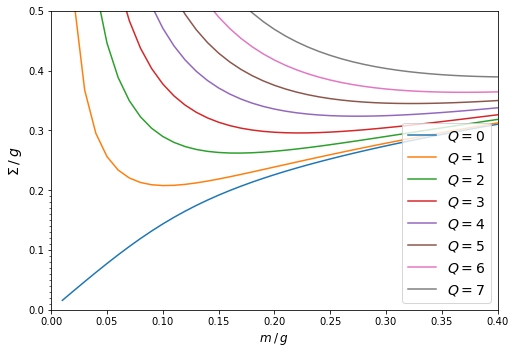

In [74]:
%%time
QsigmaVqm(allCEVs, 0.005, 0.2001, 0.005, 2, 0.5)

*Hip, 2023-08-11*